In [2]:
# -----------------------------
# 🧩 STEP 1: Load the pickled generation files
# -----------------------------
import pickle

with open("train_generations3", "rb") as f:
    train_data = pickle.load(f)

with open("validation_generations3", "rb") as f:
    val_data = pickle.load(f)

print("✅ Loaded train/val data.")
print(f"Train examples: {len(train_data)}")
print(f"Val examples: {len(val_data)}")

✅ Loaded train/val data.
Train examples: 500
Val examples: 500


In [6]:
# -----------------------------
# 🔍 STEP 2: Extract responses and entropy values
# -----------------------------
import torch

def extract_embeddings_and_entropy(data_dict):
    embeddings = []
    entropies = []

    for item in data_dict.values():
        for _, _, embedding in item["responses"]:
            if isinstance(embedding, torch.Tensor):
                embeddings.append(embedding.squeeze())  # remove extra batch dim if needed
                entropies.append(item["entropy"])

    return torch.stack(embeddings), torch.tensor(entropies)



train_embs, train_entropies = extract_embeddings_and_entropy(train_data)
val_embs, val_entropies = extract_embeddings_and_entropy(val_data)

print("Train emb shape:", train_embs.shape)
print("Val emb shape:", val_embs.shape)

Train emb shape: torch.Size([2500, 2048])
Val emb shape: torch.Size([2500, 2048])


In [7]:
import numpy as np

threshold = torch.median(train_entropies).item()
y_train = (train_entropies >= threshold).long().numpy()
y_val = (val_entropies >= threshold).long().numpy()

print(f"Entropy threshold: {threshold:.4f}")
print(f"High entropy proportion in train: {y_train.mean():.2f}")

Entropy threshold: 1.0397
High entropy proportion in train: 0.51


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Convert embeddings to numpy
train_embs = train_embs.to(torch.float32)
val_embs = val_embs.to(torch.float32)

X_train = train_embs.numpy()
X_val = val_embs.numpy()


probe = LogisticRegression(max_iter=1000)
probe.fit(X_train, y_train)

# Predict
val_probs = probe.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)

print(f"✅ Validation Accuracy: {acc:.4f}")
print(f"✅ Validation AUROC:   {auc:.4f}")

✅ Validation Accuracy: 0.5124
✅ Validation AUROC:   0.5193


c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics / Plots from the training

c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


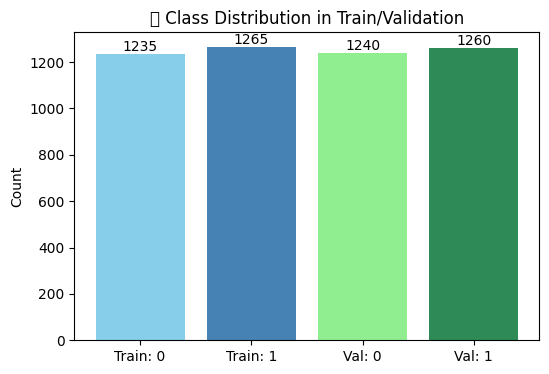

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(y_train, y_val):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(["Train: 0", "Train: 1", "Val: 0", "Val: 1"],
                   [np.sum(y_train==0), np.sum(y_train==1), np.sum(y_val==0), np.sum(y_val==1)],
                   color=["skyblue", "steelblue", "lightgreen", "seagreen"])
    plt.title("🔍 Class Distribution in Train/Validation")
    plt.ylabel("Count")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha="center", va="bottom", fontsize=10)
    plt.show()

plot_label_distribution(y_train, y_val)

c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


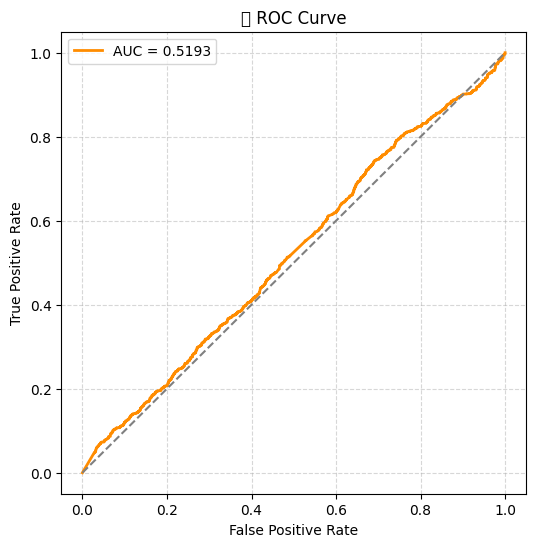

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"📉 {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_roc_curve(y_val, val_probs)


c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


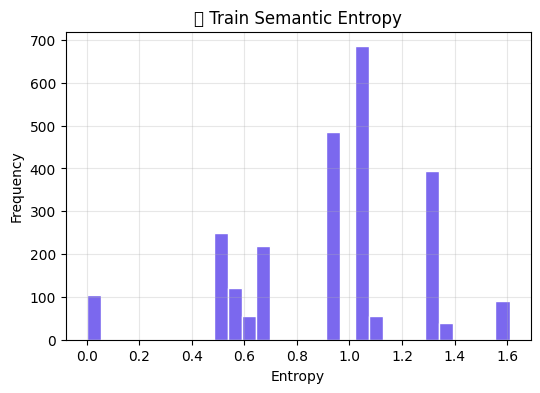

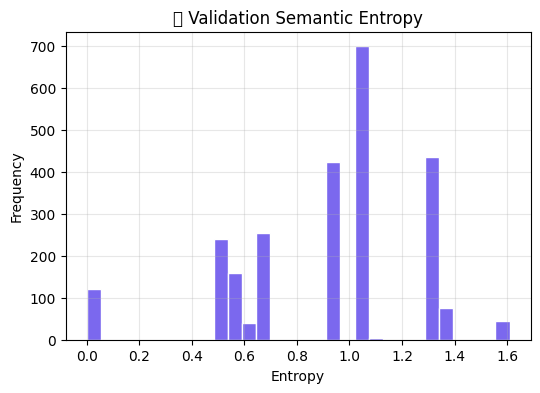

In [11]:
def plot_entropy_distribution(entropies, title="Entropy Distribution"):
    plt.figure(figsize=(6, 4))
    plt.hist(entropies, bins=30, color="mediumslateblue", edgecolor="white")
    plt.title(f"📊 {title}")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

plot_entropy_distribution(train_entropies, "Train Semantic Entropy")
plot_entropy_distribution(val_entropies, "Validation Semantic Entropy")